In [1]:
import numpy as np
import pandas as pd
import os
import random
import keras_tuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from keras_tuner import Hyperband
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [55]:
DATA_PATH = './data/images'
CNN_IMAGE_RESULTS = './results/cnn/images'
CNN_HISTORY_RESULTS = './results/cnn/history'
CNN_REPORT_RESULTS = './results/cnn/reports'
CNN_MODEL_RESULTS = './results/cnn/models'

TRAIN_DIRECTORY = 'train'
VALIDATION_DIRECTORY = 'val'
TEST_DIRECTORY = 'test'

SUB_DIRECTORIES = [TRAIN_DIRECTORY, TEST_DIRECTORY, VALIDATION_DIRECTORY]
CATEGORY_DIRECTORIES = ['Chickenpox', 'Cowpox', 'Healthy', 'HFMD', 'Measles', 'Monkeypox']

In [53]:
def count_images(dir_name):
    for dataset_type in SUB_DIRECTORIES:
        total = 0
        dir_type = os.path.join(dir_name, dataset_type)
        print(f"============ {dataset_type} dataset ===========")
        for category in os.listdir(dir_type):
            category_path = os.path.join(dir_type, category)
            if not os.path.isdir(category_path):
                continue
            images = [img for img in os.listdir(category_path) if img.endswith(('jpg','jpeg'))]
            print(f"Number of images in {category_path.split('/')[-1]}: {len(images)}")
            total += len(images)
        print(f"Total image count: {total}")
        print("")

In [56]:
count_images(DATA_PATH)

============ train dataset ===========
Number of images in Cowpox: 792
Number of images in Healthy: 1000
Number of images in HFMD: 1000
Number of images in Measles: 660
Number of images in Chickenpox: 900
Number of images in Monkeypox: 1000
Total image count: 5352

============ test dataset ===========
Number of images in Cowpox: 99
Number of images in Healthy: 100
Number of images in HFMD: 100
Number of images in Measles: 83
Number of images in Chickenpox: 100
Number of images in Monkeypox: 100
Total image count: 582

============ val dataset ===========
Number of images in Cowpox: 99
Number of images in Healthy: 100
Number of images in HFMD: 100
Number of images in Measles: 82
Number of images in Chickenpox: 100
Number of images in Monkeypox: 100
Total image count: 581



In [57]:
def load_images_to_df(base_path, dataset_type):
    path = os.path.join(base_path, dataset_type)
    image_dir = Path(path)

    file_paths = list(image_dir.glob(r'**/*.jpg'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

    file_paths = pd.Series(file_paths, name='Path').astype(str)
    labels = pd.Series(labels, name='Label')

    image_df = pd.concat([file_paths, labels], axis=1)

    samples = []
    for record in image_df['Label'].unique():
        samples.append(image_df[image_df['Label']==record])
    image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

    return image_df

In [58]:
df_train = load_images_to_df(DATA_PATH, TRAIN_DIRECTORY)
df_train.head(10)

Path       Label
0       data/images/train/Chickenpox/CHP_28_01_9.jpg  Chickenpox
1     data/images/train/Healthy/HEALTHY_100_01_7.jpg     Healthy
2          data/images/train/Cowpox/CWP_41_02_11.jpg      Cowpox
3       data/images/train/Chickenpox/CHP_41_01_7.jpg  Chickenpox
4       data/images/train/Healthy/HEALTHY_100_01.jpg     Healthy
5           data/images/train/Cowpox/CWP_10_01_1.jpg      Cowpox
6          data/images/train/Cowpox/CWP_04_01_11.jpg      Cowpox
7          data/images/train/Measles/MSL_01_01_4.jpg     Measles
8  data/images/train/Monkeypox/MKP_138_02_ORIGINA...   Monkeypox
9   data/images/train/Measles/MSL_16_01_ORIGINAL.jpg     Measles

In [59]:
df_val = load_images_to_df(DATA_PATH, VALIDATION_DIRECTORY)
df_val.head(10)

Path       Label
0    data/images/val/Monkeypox/MKP_108_03_9.jpg   Monkeypox
1        data/images/val/HFMD/HFMD_142_01_8.jpg        HFMD
2  data/images/val/Healthy/HEALTHY_11_01_13.jpg     Healthy
3   data/images/val/Chickenpox/CHP_56_01_13.jpg  Chickenpox
4    data/images/val/Chickenpox/CHP_47_01_2.jpg  Chickenpox
5        data/images/val/HFMD/HFMD_126_01_2.jpg        HFMD
6    data/images/val/Chickenpox/CHP_26_01_5.jpg  Chickenpox
7    data/images/val/Healthy/HEALTHY_102_01.jpg     Healthy
8       data/images/val/HFMD/HFMD_107_01_10.jpg        HFMD
9     data/images/val/Monkeypox/MKP_10_01_5.jpg   Monkeypox

In [60]:
df_test = load_images_to_df(DATA_PATH, TEST_DIRECTORY)
df_test.head(10)

Path       Label
0     data/images/test/Monkeypox/MKP_06_02_7.jpg   Monkeypox
1  data/images/test/HFMD/HFMD_08_01_ORIGINAL.jpg        HFMD
2   data/images/test/Healthy/HEALTHY_31_01_9.jpg     Healthy
3    data/images/test/Chickenpox/CHP_06_02_9.jpg  Chickenpox
4    data/images/test/Chickenpox/CHP_46_01_1.jpg  Chickenpox
5          data/images/test/HFMD/HFMD_104_01.jpg        HFMD
6   data/images/test/Chickenpox/CHP_09_01_12.jpg  Chickenpox
7   data/images/test/Healthy/HEALTHY_35_01_9.jpg     Healthy
8       data/images/test/Measles/MSL_20_01_9.jpg     Measles
9      data/images/test/Measles/MSL_01_02_10.jpg     Measles

In [61]:
def pie_plot_from_df(df, title):
    pie = df["Label"].value_counts()
    pie.plot(kind="pie", autopct="%1.2f%%")
    plt.ylabel("")
    plt.xlabel(title)
    plt.show()

In [62]:
def show_images_from_df(df, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8), subplot_kw={"xticks":[], "yticks":[]})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df.Path[i], -1))
        ax.set_title(df.Label[i])
    plt.tight_layout()
    plt.show()

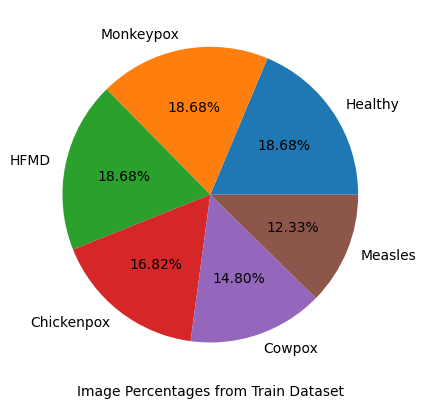

In [63]:
pie_plot_from_df(df_train, "Image Percentages from Train Dataset")

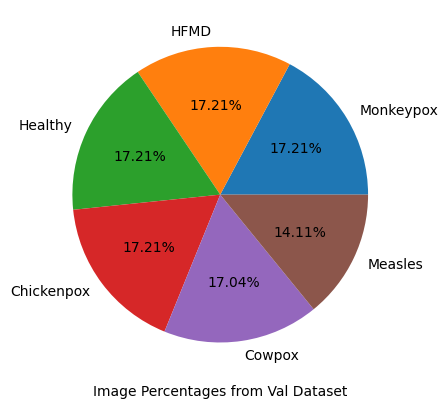

In [64]:
pie_plot_from_df(df_val, "Image Percentages from Val Dataset")

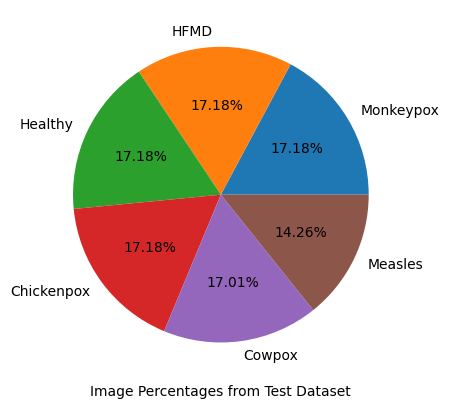

In [65]:
pie_plot_from_df(df_test, "Image Percentages from Test Dataset")

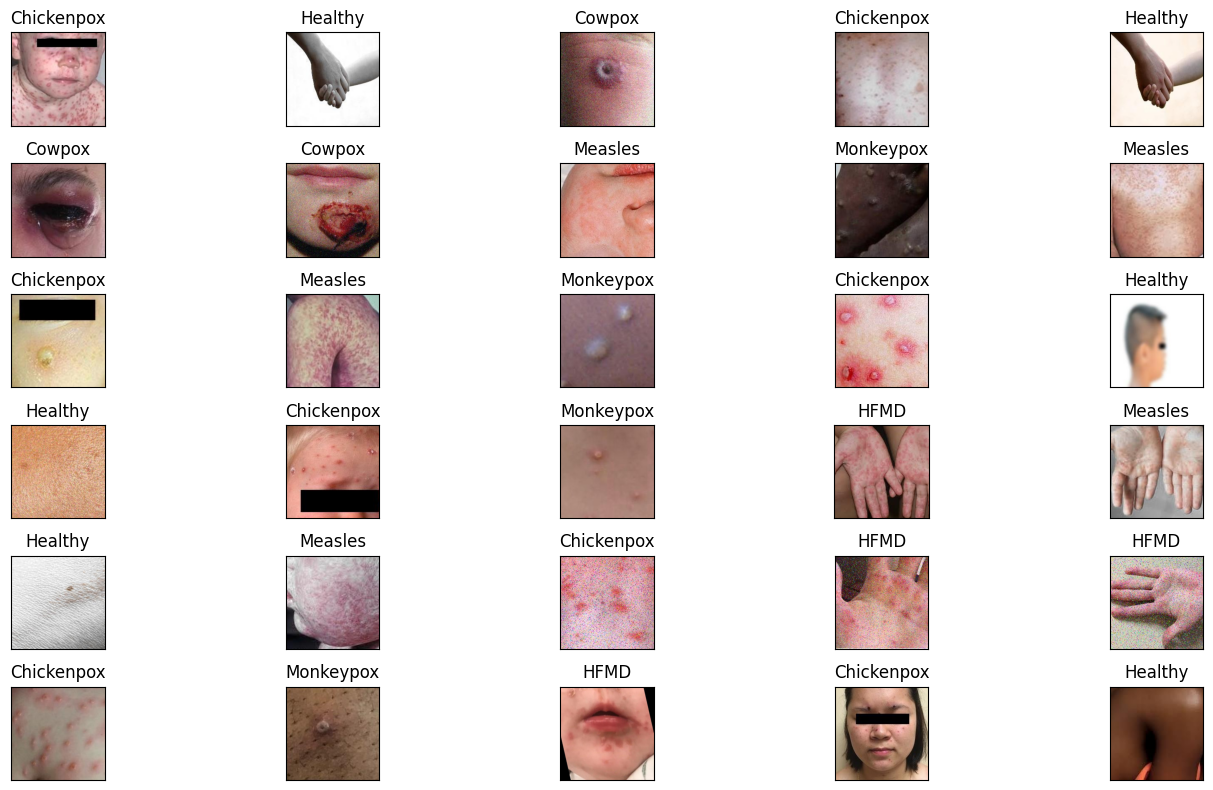

In [66]:
show_images_from_df(df_train, 6, 5)

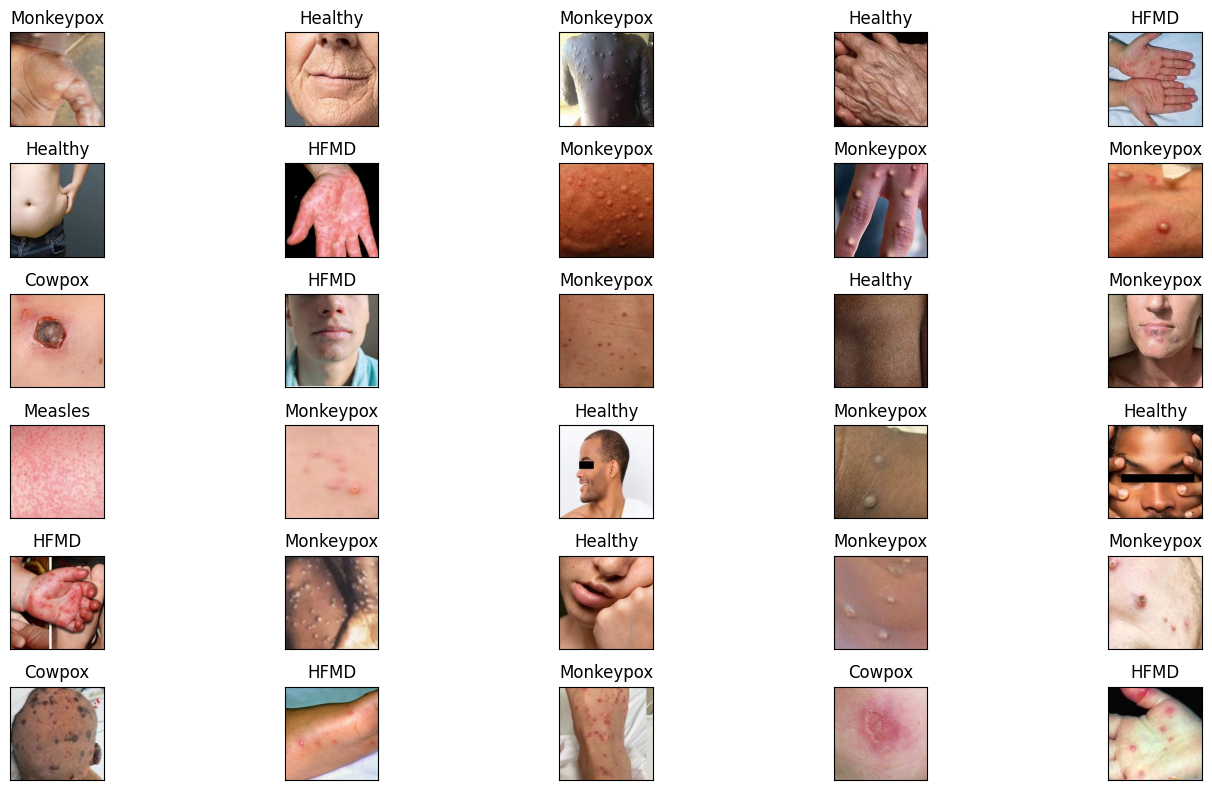

In [24]:
show_images_from_df(df_val, 6, 5)

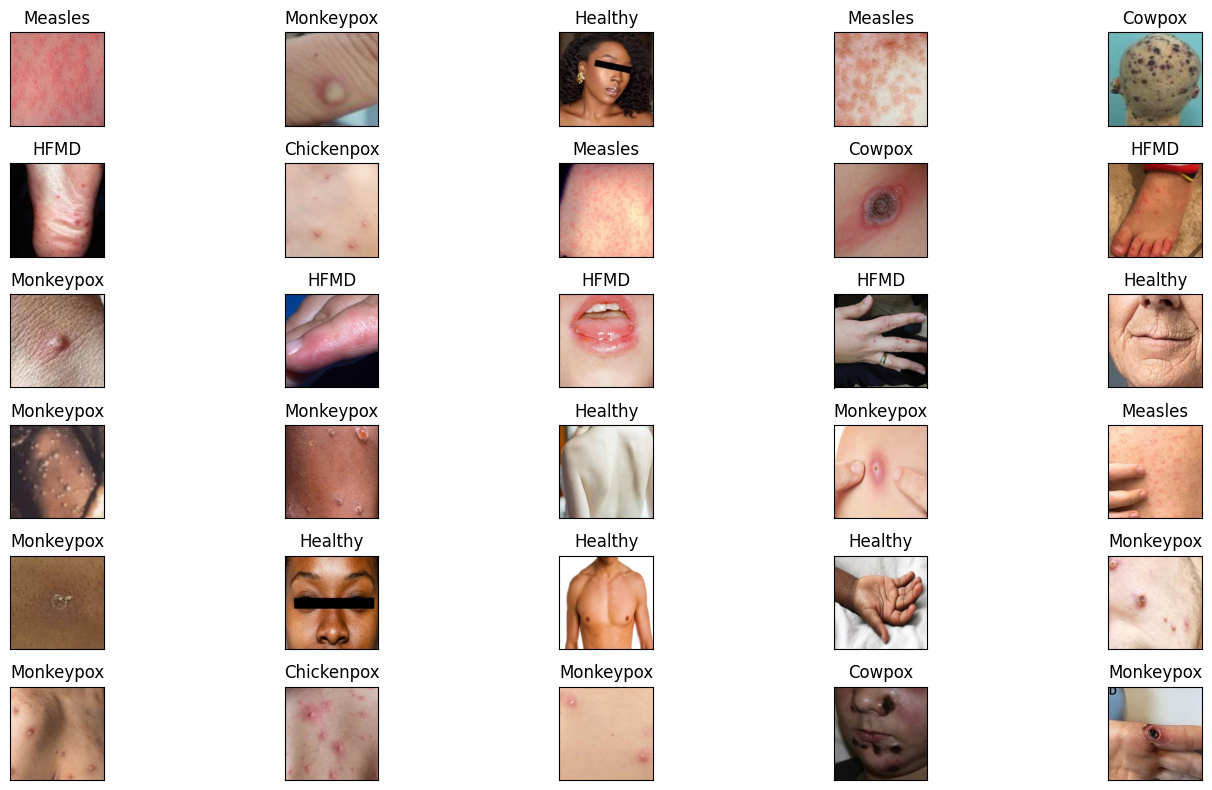

In [25]:
show_images_from_df(df_test, 6, 5)

In [67]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    channel_shift_range=0.1,
    fill_mode="nearest",
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

In [68]:
def create_dataset(generator, df, subset):
    images = generator.flow_from_dataframe(
        dataframe=df,
        x_col='Path', 
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42)
    print(f"{subset} class indices: {images.class_indices}\n")
    return images

In [69]:
train_dataset = create_dataset(train_generator, df_train, TRAIN_DIRECTORY)
val_dataset = create_dataset(val_generator, df_val, VALIDATION_DIRECTORY)
test_dataset = create_dataset(test_generator, df_test, TEST_DIRECTORY)

Found 5352 validated image filenames belonging to 6 classes.
train class indices: {'Chickenpox': 0, 'Cowpox': 1, 'HFMD': 2, 'Healthy': 3, 'Measles': 4, 'Monkeypox': 5}

Found 581 validated image filenames belonging to 6 classes.
val class indices: {'Chickenpox': 0, 'Cowpox': 1, 'HFMD': 2, 'Healthy': 3, 'Measles': 4, 'Monkeypox': 5}

Found 582 validated image filenames belonging to 6 classes.
test class indices: {'Chickenpox': 0, 'Cowpox': 1, 'HFMD': 2, 'Healthy': 3, 'Measles': 4, 'Monkeypox': 5}



## Model Based on Random Values

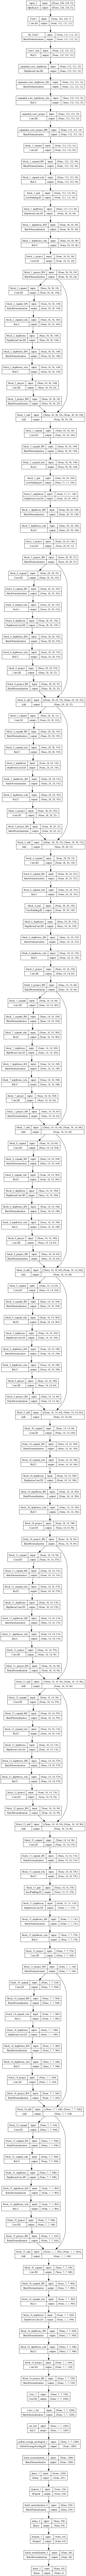

In [70]:
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

for layer in base_model.layers:
    layer.trainable = False

inputs = base_model.input

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
outputs = Dense(len(CATEGORY_DIRECTORIES), activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

tf.keras.utils.plot_model(model, f"{CNN_IMAGE_RESULTS}/mobile_net_v2_model_summary.png", show_shapes=True, dpi=50)

In [71]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)

class_weights = dict(enumerate(class_weights))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=20,
    mode="min",
    restore_best_weights=True,
    verbose=1
)

In [72]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    class_weight=class_weights
)

Epoch 1/100


2025-01-25 23:48:48.478669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


168/168 [==============================] - ETA: 0s - loss: 0.8940 - categorical_accuracy: 0.6740

2025-01-25 23:49:25.390253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


168/168 [==============================] - 40s 226ms/step - loss: 0.8940 - categorical_accuracy: 0.6740 - val_loss: 0.6130 - val_categorical_accuracy: 0.7935
Epoch 2/100
168/168 [==============================] - 38s 224ms/step - loss: 0.6223 - categorical_accuracy: 0.7756 - val_loss: 0.5277 - val_categorical_accuracy: 0.8176
Epoch 3/100
168/168 [==============================] - 38s 224ms/step - loss: 0.5559 - categorical_accuracy: 0.7973 - val_loss: 0.4662 - val_categorical_accuracy: 0.8485
Epoch 4/100
168/168 [==============================] - 38s 224ms/step - loss: 0.5114 - categorical_accuracy: 0.8154 - val_loss: 0.4519 - val_categorical_accuracy: 0.8606
Epoch 5/100
168/168 [==============================] - 38s 224ms/step - loss: 0.5020 - categorical_accuracy: 0.8130 - val_loss: 0.4575 - val_categorical_accuracy: 0.8503
Epoch 6/100
168/168 [==============================] - 38s 224ms/step - loss: 0.4717 - categorical_accuracy: 0.8275 - val_loss: 0.4624 - val_categorical_accuracy:

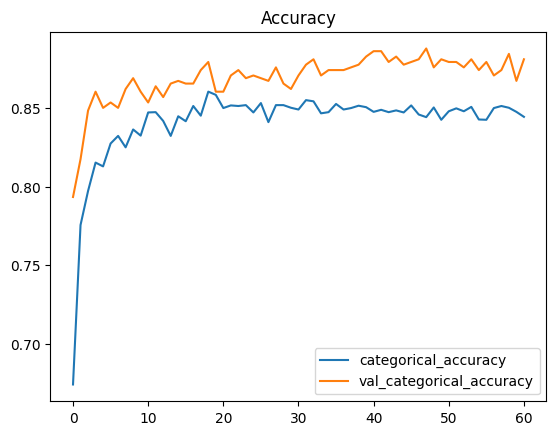

<Figure size 640x480 with 0 Axes>

In [81]:
pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()
plt.savefig(f"{CNN_IMAGE_RESULTS}/mobile_net_v2_accuracy_plot.png")

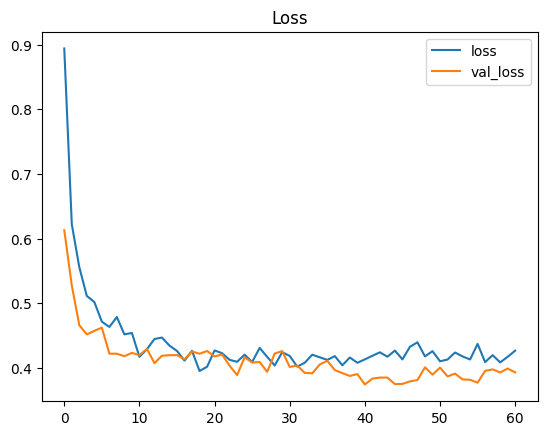

<Figure size 640x480 with 0 Axes>

In [82]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()
plt.savefig(f"{CNN_IMAGE_RESULTS}/mobile_net_v2_loss_plot.png")

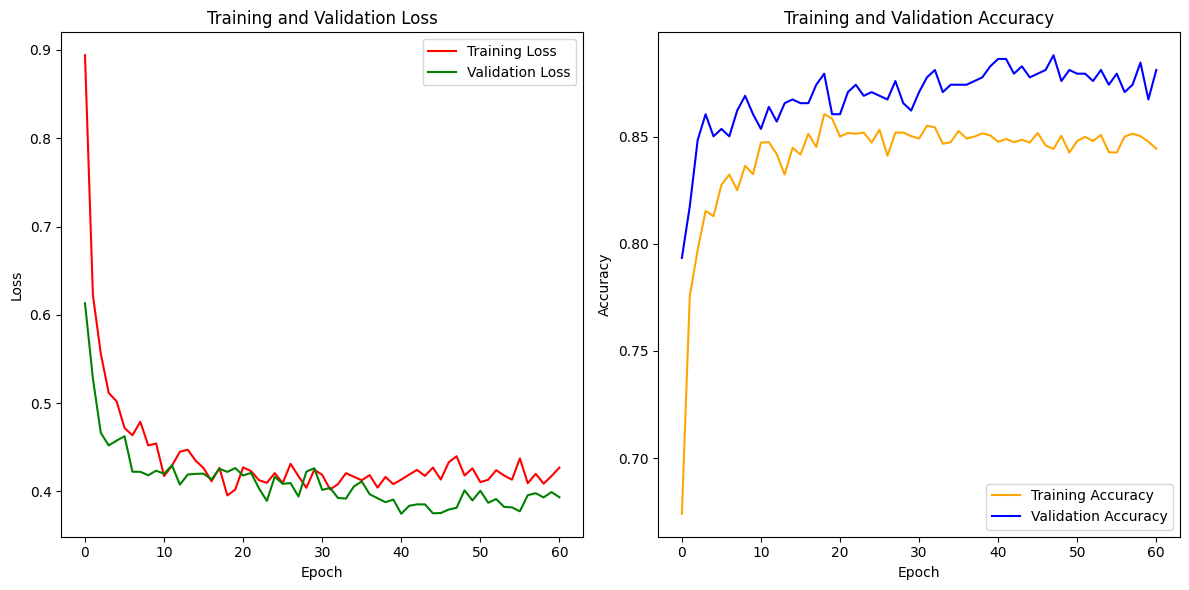

In [83]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'red', label='Training Loss')
plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], 'orange', label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig(f"{CNN_IMAGE_RESULTS}/mobile_net_v2_training_plots.png")
history_df = pd.DataFrame(history.history)
history_csv = f"{CNN_HISTORY_RESULTS}/mobile_net_v2_history.csv"
history_df.to_csv(history_csv)

In [84]:
results = model.evaluate(test_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.41739
Test Accuracy: 86.43%


In [85]:
y_pred = model.predict(test_dataset)

y_true = test_dataset.classes
y_pred = np.argmax(y_pred, axis=1)

19/19 [==============================] - 1s 38ms/step


In [86]:
report = classification_report(y_true, y_pred, target_names=test_dataset.class_indices.keys())
print("Classification Report:\n", report)

report_file = f"{CNN_REPORT_RESULTS}/mobile_net_v2_classification_report.txt"
with open(report_file, 'w') as file:
    file.write(report)

Classification Report:
               precision    recall  f1-score   support

  Chickenpox       0.18      0.18      0.18       100
      Cowpox       0.10      0.10      0.10        99
        HFMD       0.22      0.25      0.23       100
     Healthy       0.15      0.13      0.14       100
     Measles       0.11      0.10      0.10        83
   Monkeypox       0.13      0.14      0.13       100

    accuracy                           0.15       582
   macro avg       0.15      0.15      0.15       582
weighted avg       0.15      0.15      0.15       582



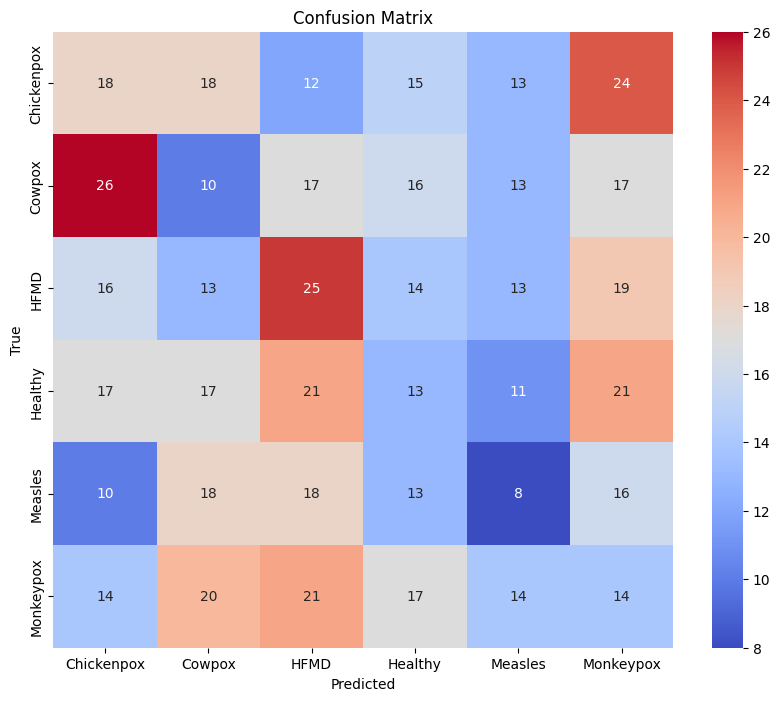

In [87]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=test_dataset.class_indices.keys(), yticklabels=test_dataset.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

heatmap_file = f'{CNN_IMAGE_RESULTS}/mobile_net_v2_confusion_matrix.png'
plt.savefig(heatmap_file)

In [88]:
model.save(f"{CNN_MODEL_RESULTS}/mobile_net_v2.h5")

2025-01-26 00:33:48.851620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 16ms/step


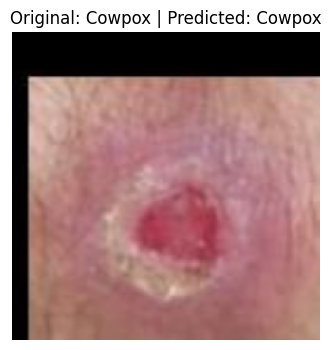

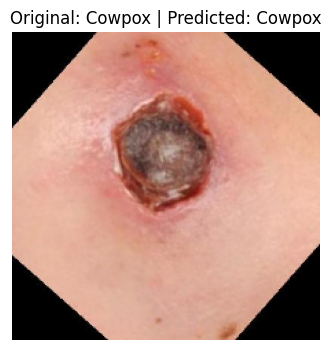

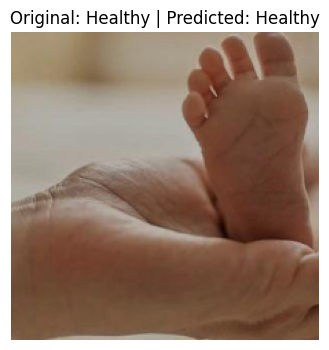

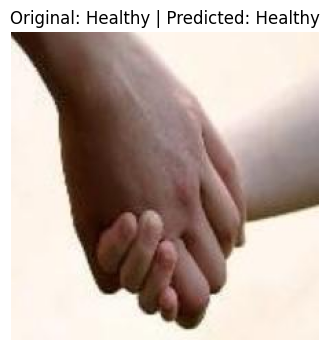

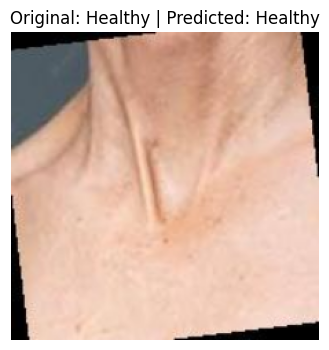

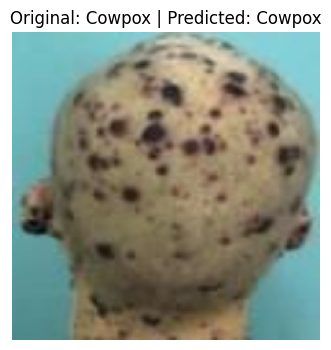

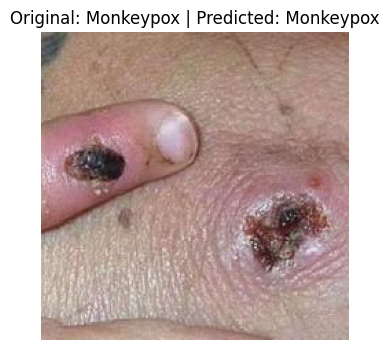

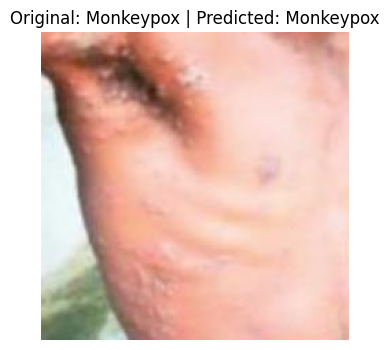

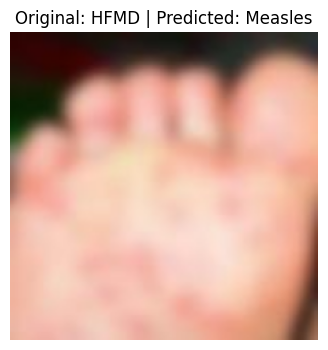

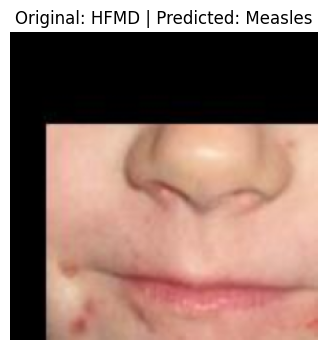

In [89]:
df_sample = df_test.sample(n=10, random_state=42)
image_dict = dict(zip(df_sample["Path"], df_sample["Label"]))

for path, label in image_dict.items():
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    preds = model.predict(img_array)
    predicted_class_idx = np.argmax(preds[0])

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")

    reversed_dict = {v: k for k, v in test_dataset.class_indices.items()}
    predicted_class = reversed_dict[predicted_class_idx]
    plt.title(f"Original: {label} | Predicted: {predicted_class}")

## Hyper-parameter Tuned Model

In [90]:
def build_model_with_hp(hp, base_model, num_classes):
    inputs = base_model.input

    x = base_model.output

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    x = Dense(units=hp.Int("dense_1_units", min_value=128, max_value=512, step=32), activation="relu")(x)
    x = Dropout(rate=hp.Choice("dropout_rate_1", values=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]))(x)

    x = BatchNormalization()(x)
    x = Dense(units=hp.Int('dense_2_units', min_value=32, max_value=512, step=16), activation='relu')(x)

    x = Dropout(rate=hp.Choice('dropout_rate_2', values=[0.2,0.3,0.4,0.5,0.6,0.7]))(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )

    return model

In [91]:
def perform_hyperparameter_tuning(model_name, base_model_func, train_dataset, val_dataset, num_classes, max_epochs=110, max_trials=5):
    base_model = base_model_func(weights="imagenet", include_top=False, input_shape=(224,224,3))

    # tuner = Hyperband(
    #     lambda hp: build_model_with_hp(hp, base_model, num_classes),
    #     objective="categorical_accuracy",
    #     max_epochs=max_epochs,
    #     factor=3,
    #     directory="hyperparameter_tuning",
    #     project_name=model_name
    # )

    tuner = RandomSearch(
        lambda hp: build_model_with_hp(hp, base_model, num_classes),
        objective="val_categorical_accuracy",
        max_trials=max_trials,  # Restrict to 5 trials
        executions_per_trial=1,
        directory="hyperparameter_tuning",
        project_name=model_name
    )

    tuner.search(train_dataset, validation_data=val_dataset, epochs=max_epochs, callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)])
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    print(f"""
    Best hyperparameters:
    - Units in Dense Layer 1: {best_hps.get('dense_1_units')}
    - Dropout Rate for Layer 1: {best_hps.get('dropout_rate_1')}
    - Units in Dense Layer 2: {best_hps.get('dense_1_units')}
    - Dropout Rate for Layer 2: {best_hps.get('dropout_rate_2')}
    - Learning Rate: {best_hps.get('learning_rate')}
    """)
    
    return tuner

In [92]:
tuner = perform_hyperparameter_tuning("MobileNetV2", MobileNetV2, train_dataset, val_dataset, len(CATEGORY_DIRECTORIES), 5)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = build_model_with_hp(best_hps, base_model, len(CATEGORY_DIRECTORIES))
tf.keras.utils.plot_model(model, f"{CNN_IMAGE_RESULTS}/mobile_net_v2_hp_model_summary.png", show_shapes=True, dpi=50)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_dataset.classes),
    y=train_dataset.classes
)

class_weights = dict(enumerate(class_weights))

history = model.fit(
    train_dataset,
    epochs=110,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)],
    class_weight=class_weights
)

Trial 5 Complete [00h 03m 23s]
val_categorical_accuracy: 0.17211703956127167

Best val_categorical_accuracy So Far: 0.2977624833583832
Total elapsed time: 00h 17m 31s

    Best hyperparameters:
    - Units in Dense Layer 1: 384
    - Dropout Rate for Layer 1: 0.2
    - Units in Dense Layer 2: 384
    - Dropout Rate for Layer 2: 0.6
    - Learning Rate: 0.001
    
Epoch 1/110


2025-01-26 00:52:10.670732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


168/168 [==============================] - ETA: 0s - loss: 0.9788 - categorical_accuracy: 0.6661

2025-01-26 00:52:49.176765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


168/168 [==============================] - 41s 234ms/step - loss: 0.9788 - categorical_accuracy: 0.6661 - val_loss: 0.5678 - val_categorical_accuracy: 0.7969
Epoch 2/110
168/168 [==============================] - 39s 229ms/step - loss: 0.6725 - categorical_accuracy: 0.7565 - val_loss: 0.5158 - val_categorical_accuracy: 0.8296
Epoch 3/110
168/168 [==============================] - 38s 228ms/step - loss: 0.5929 - categorical_accuracy: 0.7872 - val_loss: 0.4729 - val_categorical_accuracy: 0.8451
Epoch 4/110
168/168 [==============================] - 38s 228ms/step - loss: 0.5495 - categorical_accuracy: 0.8016 - val_loss: 0.4604 - val_categorical_accuracy: 0.8503
Epoch 5/110
168/168 [==============================] - 38s 226ms/step - loss: 0.5209 - categorical_accuracy: 0.8133 - val_loss: 0.4738 - val_categorical_accuracy: 0.8365
Epoch 6/110
168/168 [==============================] - 38s 228ms/step - loss: 0.4897 - categorical_accuracy: 0.8217 - val_loss: 0.4318 - val_categorical_accuracy:

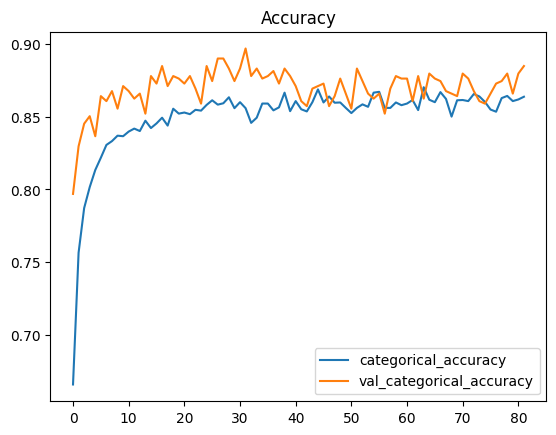

<Figure size 640x480 with 0 Axes>

In [99]:
pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()
plt.savefig(f"{CNN_IMAGE_RESULTS}/mobile_net_v2_hp_accuracy_plot.png")

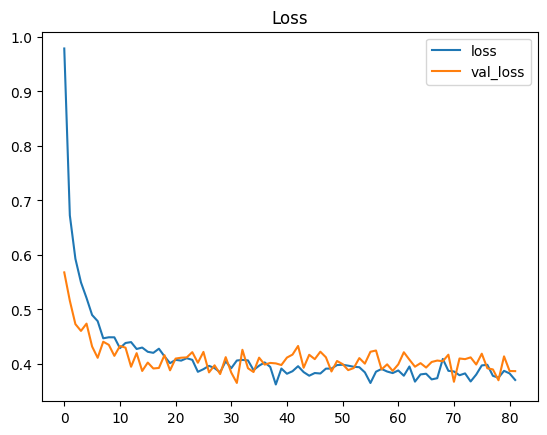

<Figure size 640x480 with 0 Axes>

In [100]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()
plt.savefig(f"{CNN_IMAGE_RESULTS}/mobile_net_v2_hp_loss_plot.png")

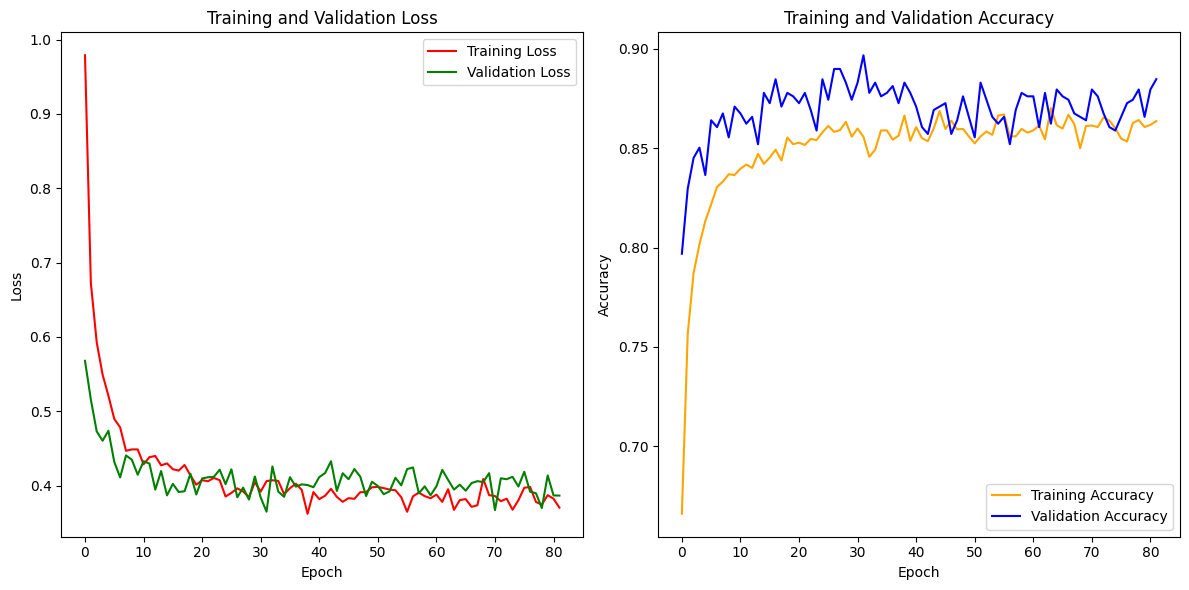

In [93]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'red', label='Training Loss')
plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], 'orange', label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], 'blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.savefig(f"{CNN_IMAGE_RESULTS}/mobile_net_v2_hp_training_plots.png")
history_df = pd.DataFrame(history.history)
history_csv = f"{CNN_HISTORY_RESULTS}/mobile_net_v2_hp_history.csv"
history_df.to_csv(history_csv)

In [101]:
results = model.evaluate(test_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.39655
Test Accuracy: 86.25%


In [94]:
y_pred = model.predict(test_dataset)

y_true = test_dataset.classes
y_pred = np.argmax(y_pred, axis=1)

2025-01-26 01:44:34.956863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 2s 48ms/step


In [95]:
report = classification_report(y_true, y_pred, target_names=test_dataset.class_indices.keys())
print("Classification Report:\n", report)

report_file = f"{CNN_REPORT_RESULTS}/mobile_net_v2_hp_classification_report.txt"
with open(report_file, 'w') as file:
    file.write(report)

Classification Report:
               precision    recall  f1-score   support

  Chickenpox       0.21      0.22      0.22       100
      Cowpox       0.14      0.15      0.14        99
        HFMD       0.20      0.20      0.20       100
     Healthy       0.23      0.21      0.22       100
     Measles       0.20      0.18      0.19        83
   Monkeypox       0.17      0.17      0.17       100

    accuracy                           0.19       582
   macro avg       0.19      0.19      0.19       582
weighted avg       0.19      0.19      0.19       582



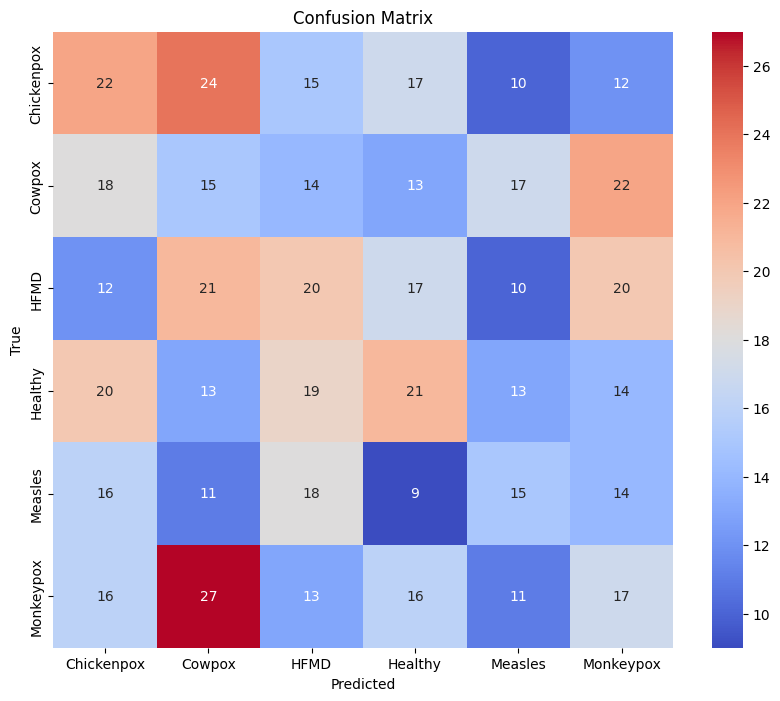

In [96]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=test_dataset.class_indices.keys(), yticklabels=test_dataset.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

heatmap_file = f'{CNN_IMAGE_RESULTS}/mobile_net_v2_hp_confusion_matrix.png'
plt.savefig(heatmap_file)

In [97]:
model.save(f"{CNN_MODEL_RESULTS}/mobile_net_v2_hp.h5")

2025-01-26 01:44:37.690243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 15ms/step


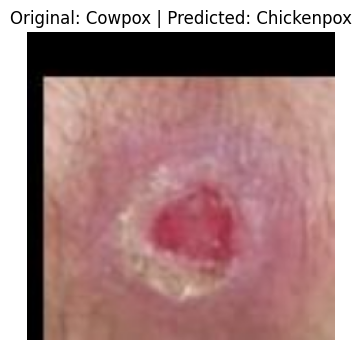

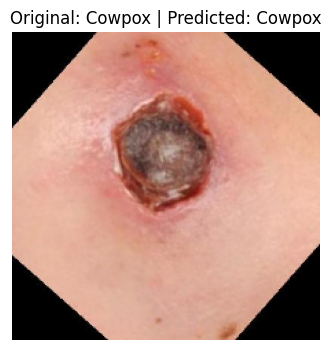

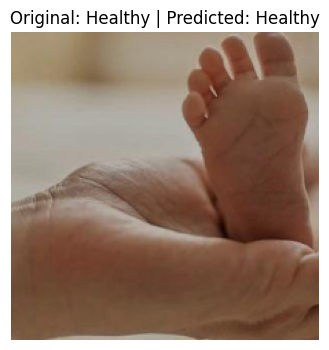

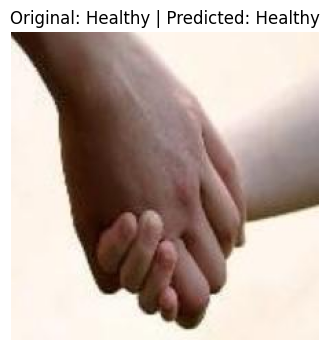

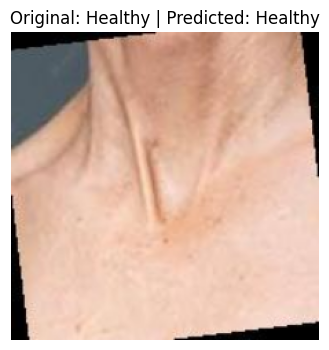

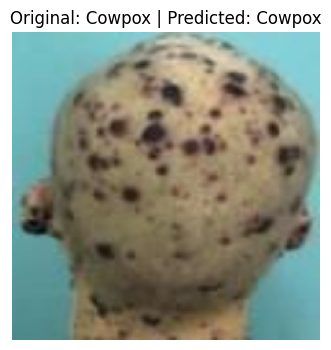

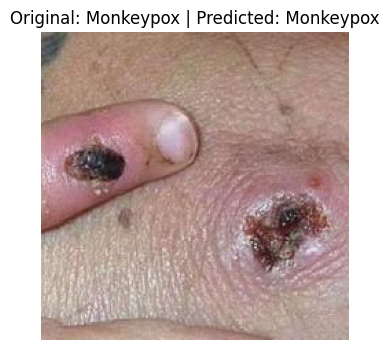

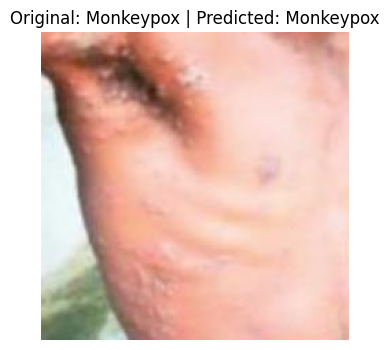

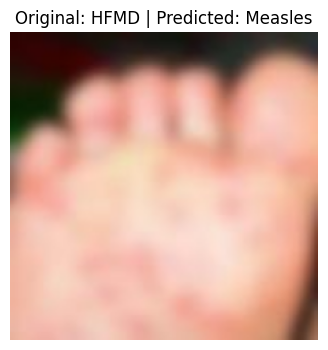

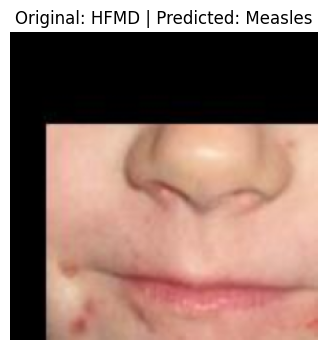

In [98]:
df_sample = df_test.sample(n=10, random_state=42)
image_dict = dict(zip(df_sample["Path"], df_sample["Label"]))

for path, label in image_dict.items():
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)

    preds = model.predict(img_array)
    predicted_class_idx = np.argmax(preds[0])

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")

    reversed_dict = {v: k for k, v in test_dataset.class_indices.items()}
    predicted_class = reversed_dict[predicted_class_idx]
    plt.title(f"Original: {label} | Predicted: {predicted_class}")